In [1]:
# Example from https://github.com/wcneill/jn-ml-textbook/blob/master/Deep%20Learning/04%20Recurrent%20Networks/pytorch13b_LSTM.ipynb

import torch
from torch import nn, optim
import optuna

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from ta import add_all_ta_features #pip install --upgrade ta https://github.com/bukosabino/ta https://medium.datadriveninvestor.com/predicting-the-stock-market-with-python-bba3cf4c56ef
from fastai.tabular.all import add_datepart #pip install fastai https://docs.fast.ai/tabular.core.html https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

mpl.rcParams['figure.figsize'] = [12,8]
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv('data/AAPL_data.csv')
df.dropna()

df["Date"]=pd.to_datetime(df.Date, format="%Y-%m-%d")
df.index=df['Date']
data = df.sort_index(ascending=True, axis=0)
add_datepart(df, 'Date', drop=False)
df.drop('Elapsed', axis=1, inplace=True)

df = add_all_ta_features(
    df, high="High", low="Low", open="Open", close="Close", volume="Volume")

print(f'Number of Entries: {len(df)}')
df.head()

Number of Entries: 1260


/Users/alejandrosaenz/opt/anaconda3/lib/python3.9/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/alejandrosaenz/opt/anaconda3/lib/python3.9/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


,Date,High,Low,Open,Close,Volume,Adj Close,Year,Month,Week,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-28,2017-04-28,36.075001,35.817501,36.022499,35.912498,83441600.0,33.907143,2017,4,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-56.906234,NaN,0.000000
2017-05-01,2017-05-01,36.799999,36.240002,36.275002,36.645000,134411600.0,34.598736,2017,5,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.039685,2.019162,2.039685
2017-05-02,2017-05-02,37.022499,36.709999,36.884998,36.877499,181408800.0,34.818253,2017,5,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.634461,0.632457,2.687087
2017-05-03,2017-05-03,36.872501,36.067501,36.397499,36.764999,182788000.0,34.712040,2017,5,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.305062,-0.305528,2.373828
2017-05-04,2017-05-04,36.785000,36.452499,36.630001,36.632500,93487600.0,34.586937,2017,5,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.360396,-0.361047,2.004876


/Users/alejandrosaenz/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


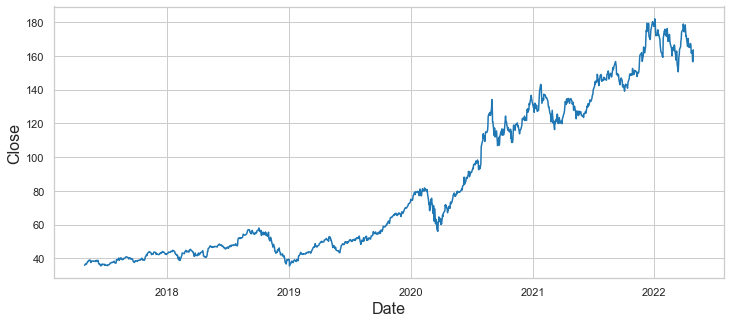

In [3]:
plt.figure(figsize=[12., 5.])
ax = sns.lineplot(df.index, df.Close, data=df)
#ax.set_xlabel('months');

In [4]:
# Select time frame
df = df[df['Date'] >= '2022-01-01']

# Create y variable
y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)

# Select features 
selected_features = ['trend_sma_fast', 'trend_ema_fast', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_rsi', \
                    'trend_macd', 'momentum_wr', 'volume_adi', 'momentum_roc', 'volume_obv', \
                    'volatility_bbh', 'volatility_bbl']
basic_features = ['High', 'Low', 'Open', 'Volume', 'Year', 'Month', 'Week', 'Day', 'Dayofweek']

reduced_df = df[selected_features + basic_features]



In [5]:
tscv = TimeSeriesSplit(n_splits=5)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [6]:
# Convert data to float32 for PyTorch
reduced_df = reduced_df.astype(np.float32)

# I'm going to convert this to train and test instead of train and valid.
# Train will include validation set through cross validation.

# Split training and validation data
split = int(0.8 * len(df))
x_train = reduced_df[:split].to_numpy() #.reshape(-1, 1)
x_test = reduced_df[split:].to_numpy() #.reshape(-1, 1)

y_train = y[:split].reshape(-1, 1)
y_test = y[split:].reshape(-1, 1)

# scale data: MOVED THIS TO HAPPEN WITHIN CROSS VALIDATION

# t_scaler = MinMaxScaler(feature_range=(-1, 1))
# v_scaler = MinMaxScaler(feature_range=(-1, 1))
# x_train = t_scaler.fit_transform(x_train)
# x_test = v_scaler.fit_transform(x_test)

# convert training data to tensor
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [7]:
# Create training and validation set:
train_data = (x_train, y_train)
test_data = (x_test, y_test)

In [8]:
def get_batches(data, window):
    """
    Takes data with shape (n_samples, n_features) and creates mini-batches
    with shape (1, window). 
    """
    x_data, y_data = data
    L = len(x_data)
    for i in range(L - window):
        x_sequence = x_data[i:i + window]
        y_sequence = y_data[i:i + window]
        yield x_sequence, y_sequence

In [9]:
class stocksLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hs):
   
        out, hs = self.lstm(x, hs)           # out.shape = (batch_size, seq_len, hidden_size)
        out = out.view(-1, self.hidden_size) # out.shape = (seq_len, hidden_size)     
        out = self.fc(out)
        
        return out, hs

In [11]:
def train(model, epochs, train_set, valid_data=None, lr=0.001, print_every=100):

    criterion = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    
    train_loss = []
    valid_loss = []
    
    for e in range(epochs):
        
        hs = None
        t_loss = 0
        for x, y in get_batches(train_set, 12):

            opt.zero_grad()
            
            # Create batch_size dimension
            x = x.unsqueeze(0)
            out, hs = model(x, hs)
            hs = tuple([h.data for h in hs])
            
            loss = criterion(out, y)
            loss.backward()
            opt.step()
            t_loss += loss.item()
            
        if valid_data is not None:
                model.eval()
                val_x, val_y = valid_data
                val_x = val_x.unsqueeze(0)
                preds, _ = model(val_x, hs)
                v_loss = criterion(preds, val_y)
                valid_loss.append(v_loss.item())
                
                model.train()
            
        train_loss.append(np.mean(t_loss))
            
            
        if e % print_every == 0:
            print(f'Epoch {e}:\nTraining Loss: {train_loss[-1]}')
            if valid_data is not None:
                print(f'Validation Loss: {valid_loss[-1]}')
        
    return train_loss, valid_loss
    
#     plt.figure(figsize=[8., 6.])
#     plt.plot(train_loss, label='Training Loss')
#     plt.plot(valid_loss, label='Validation Loss')
#     plt.title('Loss vs Epochs')
#     plt.xlabel('Epochs')
#     plt.legend()
#     plt.show()

In [12]:
def train_cross_valid(model, epochs, lr, training_data):
    train_losses = []
    valid_losses = []
    X_train, y_train = training_data
    for train_index, validation_index in tscv.split(X_train):
        # print("TRAIN:", train_index, "VALIDATION:", validation_index)
        # Split training and validation data
        # split = int(0.8 * len(df))
        # x_train = X_train[train_index].to_numpy() #.reshape(-1, 1)
        # x_valid = X_train[validation_index].to_numpy() #.reshape(-1, 1)
        x_train_fold = X_train[train_index]
        x_valid_fold = X_train[validation_index]

        y_train_fold = y[train_index].reshape(-1, 1)
        y_valid_fold = y[validation_index].reshape(-1, 1)

        # scale data
        # t_scaler = MinMaxScaler(feature_range=(-1, 1))
        # v_scaler = MinMaxScaler(feature_range=(-1, 1))
        t_scaler = MinMaxScaler()
        x_train_fold = t_scaler.fit_transform(x_train_fold)
        x_valid_fold = t_scaler.transform(x_valid_fold)

        # convert training data to tensor
        x_train_fold = torch.tensor(x_train_fold, dtype=torch.float32)
        x_valid_fold = torch.tensor(x_valid_fold, dtype=torch.float32)

        y_train_fold = torch.tensor(y_train_fold, dtype=torch.float32)
        y_valid_fold = torch.tensor(y_valid_fold, dtype=torch.float32)

        # Create training and validation set:
        train_data_fold = (x_train_fold, y_train_fold)
        valid_data_fold = (x_valid_fold, y_valid_fold)
        
        train_loss, valid_loss = train(model, epochs, train_data_fold, valid_data=valid_data_fold, lr=lr)
                #Only append losses from the last epoch
        train_losses.append(train_loss[-1])
        valid_losses.append(valid_loss[-1])

    # Compute              
    train_losses_avg = sum(train_losses) / len(train_losses)   
    valid_losses_avg = sum(valid_losses) / len(valid_losses)  
    return train_losses_avg, valid_losses_avg

In [13]:
# Optuna objective function

def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              #'num_layers': trial.suggest_int('num_layers', 1, 4)
              }
    
    input_size = x_train.size()[1]  # 21 in current implementation
    hidden_size = 100
    num_layers = 1     # tuned by optuna
    output_size = 1

    model = stocksLSTM(input_size, hidden_size, num_layers, output_size)
    
    train_losses_avg, valid_losses_avg = train_cross_valid(model, EPOCHS, params['learning_rate'], train_data)

    #train_losses_avg, valid_losses_avg = train(model, EPOCHS, train_data, valid_data=test_data, lr=params['learning_rate'])

    return valid_losses_avg

In [14]:
EPOCHS = 100

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

[I 2022-05-31 05:22:25,694] A new study created in memory with name: no-name-9c9aac5b-9053-4b30-91dc-d66f8b4b7a88


Epoch 0:
Training Loss: 21.21416997909546
Validation Loss: 6.924756050109863
Epoch 0:
Training Loss: 7.579647406935692
Validation Loss: 0.9487937688827515
Epoch 0:
Training Loss: 13.669071193784475
Validation Loss: 1.6940510272979736
Epoch 0:
Training Loss: 11.02535017952323
Validation Loss: 2.835766077041626
Epoch 0:
Training Loss: 12.878204081906006
Validation Loss: 3.777923107147217


[I 2022-05-31 05:22:56,756] Trial 0 finished with value: 2.094768214225769 and parameters: {'learning_rate': 0.08829840625475222}. Best is trial 0 with value: 2.094768214225769.


Epoch 0:
Training Loss: 2.04768168926239
Validation Loss: 1.075735092163086
Epoch 0:
Training Loss: 9.991033732891083
Validation Loss: 0.947455883026123
Epoch 0:
Training Loss: 16.79190543293953
Validation Loss: 1.4211761951446533
Epoch 0:
Training Loss: 27.28315159678459
Validation Loss: 3.118234634399414
Epoch 0:
Training Loss: 30.03859308362007
Validation Loss: 2.935786724090576


[I 2022-05-31 05:23:28,127] Trial 1 finished with value: 1.6082494616508485 and parameters: {'learning_rate': 5.587686935485507e-05}. Best is trial 1 with value: 1.6082494616508485.


Epoch 0:
Training Loss: 2.0320189595222473
Validation Loss: 0.8936642408370972
Epoch 0:
Training Loss: 9.38554361462593
Validation Loss: 0.8658539652824402
Epoch 0:
Training Loss: 7.767384209670126
Validation Loss: 2.674598217010498
Epoch 0:
Training Loss: 9.065895394887775
Validation Loss: 2.068526268005371
Epoch 0:
Training Loss: 6.859680869150907
Validation Loss: 2.6210224628448486


[I 2022-05-31 05:23:59,764] Trial 2 finished with value: 1.6521417856216432 and parameters: {'learning_rate': 0.005326457581709616}. Best is trial 1 with value: 1.6082494616508485.


Epoch 0:
Training Loss: 1.8835701942443848
Validation Loss: 0.9640415906906128
Epoch 0:
Training Loss: 7.999322900548577
Validation Loss: 1.036980390548706
Epoch 0:
Training Loss: 6.025779250077903
Validation Loss: 1.6907050609588623
Epoch 0:
Training Loss: 8.346181416884065
Validation Loss: 1.5154855251312256
Epoch 0:
Training Loss: 8.925393818179145
Validation Loss: 2.3736841678619385


[I 2022-05-31 05:24:30,995] Trial 3 finished with value: 1.6637834310531616 and parameters: {'learning_rate': 0.013853873815232946}. Best is trial 1 with value: 1.6082494616508485.


Epoch 0:
Training Loss: 2.077437162399292
Validation Loss: 0.9967111349105835
Epoch 0:
Training Loss: 13.337074518203735
Validation Loss: 2.264295816421509
Epoch 0:
Training Loss: 9.439534718170762
Validation Loss: 1.1037250757217407
Epoch 0:
Training Loss: 8.281958268489689
Validation Loss: 1.0531370639801025
Epoch 0:
Training Loss: 9.034260817570612
Validation Loss: 2.280992031097412


[I 2022-05-31 05:25:02,392] Trial 4 finished with value: 1.5916697263717652 and parameters: {'learning_rate': 0.0006672786006222941}. Best is trial 4 with value: 1.5916697263717652.


Epoch 0:
Training Loss: 2.021241784095764
Validation Loss: 0.8898190259933472
Epoch 0:
Training Loss: 9.922945328056812
Validation Loss: 1.430703043937683
Epoch 0:
Training Loss: 6.82706279726699
Validation Loss: 0.77797931432724
Epoch 0:
Training Loss: 6.449818496126682
Validation Loss: 2.456174612045288
Epoch 0:
Training Loss: 6.976110627874732
Validation Loss: 2.142575979232788


[I 2022-05-31 05:25:33,628] Trial 5 finished with value: 1.7582888841629027 and parameters: {'learning_rate': 0.0041881258142127745}. Best is trial 4 with value: 1.5916697263717652.


Epoch 0:
Training Loss: 1.9680277705192566
Validation Loss: 0.932492733001709
Epoch 0:
Training Loss: 11.53422112390399
Validation Loss: 2.300535202026367
Epoch 0:
Training Loss: 10.09726282209158
Validation Loss: 0.856238067150116
Epoch 0:
Training Loss: 6.885965825989842
Validation Loss: 1.0757108926773071
Epoch 0:
Training Loss: 6.706053753383458
Validation Loss: 2.0159847736358643


[I 2022-05-31 05:26:04,598] Trial 6 finished with value: 1.3858996272087096 and parameters: {'learning_rate': 0.0010616217279111938}. Best is trial 6 with value: 1.3858996272087096.


Epoch 0:
Training Loss: 2.4965356588363647
Validation Loss: 0.9018424153327942
Epoch 0:
Training Loss: 8.80966541916132
Validation Loss: 1.0685641765594482
Epoch 0:
Training Loss: 6.567349111195654
Validation Loss: 2.1007800102233887
Epoch 0:
Training Loss: 9.05463343928568
Validation Loss: 2.4039463996887207
Epoch 0:
Training Loss: 8.082352126017213
Validation Loss: 2.5205376148223877


[I 2022-05-31 05:26:35,981] Trial 7 finished with value: 1.7186083793640137 and parameters: {'learning_rate': 0.016025815245625734}. Best is trial 6 with value: 1.3858996272087096.


Epoch 0:
Training Loss: 2.1280258893966675
Validation Loss: 1.1207865476608276
Epoch 0:
Training Loss: 12.466455191373825
Validation Loss: 0.7150686979293823
Epoch 0:
Training Loss: 15.863396495580673
Validation Loss: 1.316311001777649
Epoch 0:
Training Loss: 17.022884994745255
Validation Loss: 1.7809054851531982
Epoch 0:
Training Loss: 13.801682330667973
Validation Loss: 2.127394676208496


[I 2022-05-31 05:27:06,965] Trial 8 finished with value: 1.267134702205658 and parameters: {'learning_rate': 0.00011428176342864483}. Best is trial 8 with value: 1.267134702205658.


Epoch 0:
Training Loss: 6.0142048597335815
Validation Loss: 1.2336920499801636
Epoch 0:
Training Loss: 14.371115036308765
Validation Loss: 1.2660369873046875
Epoch 0:
Training Loss: 5.490885394625366
Validation Loss: 1.507899284362793
Epoch 0:
Training Loss: 13.781731377355754
Validation Loss: 2.1287243366241455
Epoch 0:
Training Loss: 9.149940148927271
Validation Loss: 2.0922207832336426


[I 2022-05-31 05:27:38,447] Trial 9 finished with value: 1.7376862287521362 and parameters: {'learning_rate': 0.035479553259515344}. Best is trial 8 with value: 1.267134702205658.


Epoch 0:
Training Loss: 1.9792308807373047
Validation Loss: 0.9314318895339966
Epoch 0:
Training Loss: 11.085681021213531
Validation Loss: 0.9672454595565796
Epoch 0:
Training Loss: 19.639455258846283
Validation Loss: 1.0240414142608643
Epoch 0:
Training Loss: 28.903720498085022
Validation Loss: 1.2336198091506958
Epoch 0:
Training Loss: 36.58432739973068
Validation Loss: 1.2015050649642944


[I 2022-05-31 05:28:10,494] Trial 10 finished with value: 1.067104709148407 and parameters: {'learning_rate': 1.596597162042871e-05}. Best is trial 10 with value: 1.067104709148407.


Epoch 0:
Training Loss: 2.0276989936828613
Validation Loss: 1.098483681678772
Epoch 0:
Training Loss: 11.71979534626007
Validation Loss: 0.9813909530639648
Epoch 0:
Training Loss: 19.8136568069458
Validation Loss: 1.0054339170455933
Epoch 0:
Training Loss: 29.18710607290268
Validation Loss: 1.104546308517456
Epoch 0:
Training Loss: 37.898126900196075
Validation Loss: 1.1271893978118896


[I 2022-05-31 05:28:41,477] Trial 11 finished with value: 1.0899558544158936 and parameters: {'learning_rate': 1.0916081319985071e-05}. Best is trial 10 with value: 1.067104709148407.


Epoch 0:
Training Loss: 2.011061191558838
Validation Loss: 1.016033411026001
Epoch 0:
Training Loss: 11.473621368408203
Validation Loss: 0.9903925061225891
Epoch 0:
Training Loss: 20.066387832164764
Validation Loss: 1.0452232360839844
Epoch 0:
Training Loss: 29.259506821632385
Validation Loss: 1.0776546001434326
Epoch 0:
Training Loss: 37.88406604528427
Validation Loss: 1.0817662477493286


[I 2022-05-31 05:29:12,504] Trial 12 finished with value: 1.056796371936798 and parameters: {'learning_rate': 1.2272115931725564e-05}. Best is trial 12 with value: 1.056796371936798.


Epoch 0:
Training Loss: 2.094849467277527
Validation Loss: 1.1586720943450928
Epoch 0:
Training Loss: 12.012412130832672
Validation Loss: 1.0052565336227417
Epoch 0:
Training Loss: 19.899238526821136
Validation Loss: 1.0042914152145386
Epoch 0:
Training Loss: 29.236577451229095
Validation Loss: 1.05977463722229
Epoch 0:
Training Loss: 38.02872109413147
Validation Loss: 1.0747673511505127


[I 2022-05-31 05:29:43,745] Trial 13 finished with value: 1.0324972510337829 and parameters: {'learning_rate': 1.0881972035128908e-05}. Best is trial 13 with value: 1.0324972510337829.


Epoch 0:
Training Loss: 1.9519785046577454
Validation Loss: 0.926045298576355
Epoch 0:
Training Loss: 9.969133913516998
Validation Loss: 0.9454225301742554
Epoch 0:
Training Loss: 16.5184665620327
Validation Loss: 1.5092613697052002
Epoch 0:
Training Loss: 23.86691877245903
Validation Loss: 1.3826018571853638
Epoch 0:
Training Loss: 29.14474508166313
Validation Loss: 2.340303659439087


[I 2022-05-31 05:30:15,131] Trial 14 finished with value: 1.3818063735961914 and parameters: {'learning_rate': 5.7213425330136e-05}. Best is trial 13 with value: 1.0324972510337829.


Epoch 0:
Training Loss: 2.0561150312423706
Validation Loss: 1.1363525390625
Epoch 0:
Training Loss: 14.420366376638412
Validation Loss: 0.7401487827301025
Epoch 0:
Training Loss: 14.931643158197403
Validation Loss: 0.9704140424728394
Epoch 0:
Training Loss: 14.718315064907074
Validation Loss: 1.3705137968063354
Epoch 0:
Training Loss: 12.229424806311727
Validation Loss: 2.8631398677825928


[I 2022-05-31 05:30:46,254] Trial 15 finished with value: 1.5153886079788208 and parameters: {'learning_rate': 0.00019156913241992227}. Best is trial 13 with value: 1.0324972510337829.


Epoch 0:
Training Loss: 1.9280112981796265
Validation Loss: 0.9444108009338379
Epoch 0:
Training Loss: 10.803183853626251
Validation Loss: 0.9470708966255188
Epoch 0:
Training Loss: 19.51901340484619
Validation Loss: 1.1607043743133545
Epoch 0:
Training Loss: 27.25054180622101
Validation Loss: 1.2632510662078857
Epoch 0:
Training Loss: 28.064331024885178
Validation Loss: 1.8113654851913452


[I 2022-05-31 05:31:18,103] Trial 16 finished with value: 1.3134838461875915 and parameters: {'learning_rate': 2.7695496292898306e-05}. Best is trial 13 with value: 1.0324972510337829.


Epoch 0:
Training Loss: 2.1889808177948
Validation Loss: 1.0830737352371216
Epoch 0:
Training Loss: 13.45195946097374
Validation Loss: 0.9094033241271973
Epoch 0:
Training Loss: 15.007929250597954
Validation Loss: 0.7427927255630493
Epoch 0:
Training Loss: 12.732720650732517
Validation Loss: 1.0833876132965088
Epoch 0:
Training Loss: 8.338809830136597
Validation Loss: 2.6125423908233643


[I 2022-05-31 05:31:50,844] Trial 17 finished with value: 1.7819419741630553 and parameters: {'learning_rate': 0.00025616602591798477}. Best is trial 13 with value: 1.0324972510337829.


Epoch 0:
Training Loss: 1.9717366695404053
Validation Loss: 0.9338874816894531
Epoch 0:
Training Loss: 10.809603869915009
Validation Loss: 0.9600046277046204
Epoch 0:
Training Loss: 19.38944387435913
Validation Loss: 1.1259739398956299
Epoch 0:
Training Loss: 25.750610530376434
Validation Loss: 1.5807750225067139
Epoch 0:
Training Loss: 29.555152595043182
Validation Loss: 1.6684538125991821


[I 2022-05-31 05:32:21,894] Trial 18 finished with value: 1.3719857692718507 and parameters: {'learning_rate': 3.5675777636287625e-05}. Best is trial 13 with value: 1.0324972510337829.


Epoch 0:
Training Loss: 1.9641681909561157
Validation Loss: 0.9460643529891968
Epoch 0:
Training Loss: 11.06499433517456
Validation Loss: 0.9508941769599915
Epoch 0:
Training Loss: 19.76913696527481
Validation Loss: 1.0349994897842407
Epoch 0:
Training Loss: 29.10162127017975
Validation Loss: 1.1676989793777466
Epoch 0:
Training Loss: 37.67911607027054
Validation Loss: 1.1062653064727783


[I 2022-05-31 05:32:51,743] Trial 19 finished with value: 1.0459560751914978 and parameters: {'learning_rate': 1.0038026950773916e-05}. Best is trial 13 with value: 1.0324972510337829.


Epoch 0:
Training Loss: 2.020720601081848
Validation Loss: 1.0303446054458618
Epoch 0:
Training Loss: 15.67498368024826
Validation Loss: 0.6485188007354736
Epoch 0:
Training Loss: 10.236028019338846
Validation Loss: 1.4053019285202026
Epoch 0:
Training Loss: 8.244706680066884
Validation Loss: 1.0787101984024048
Epoch 0:
Training Loss: 7.079724004492164
Validation Loss: 2.158407688140869


[I 2022-05-31 05:33:21,860] Trial 20 finished with value: 1.4955351114273072 and parameters: {'learning_rate': 0.0006119433397196516}. Best is trial 13 with value: 1.0324972510337829.


Epoch 0:
Training Loss: 1.9557662606239319
Validation Loss: 1.0126641988754272
Epoch 0:
Training Loss: 10.92069411277771
Validation Loss: 0.9525216221809387
Epoch 0:
Training Loss: 19.520683109760284
Validation Loss: 1.0304901599884033
Epoch 0:
Training Loss: 28.89763629436493
Validation Loss: 1.262905478477478
Epoch 0:
Training Loss: 36.16564458608627
Validation Loss: 1.1791181564331055


[I 2022-05-31 05:33:51,894] Trial 21 finished with value: 1.126254403591156 and parameters: {'learning_rate': 1.5510327199711175e-05}. Best is trial 13 with value: 1.0324972510337829.


Epoch 0:
Training Loss: 2.085631489753723
Validation Loss: 1.1042250394821167
Epoch 0:
Training Loss: 12.065263986587524
Validation Loss: 1.0055822134017944
Epoch 0:
Training Loss: 20.031684577465057
Validation Loss: 1.004394769668579
Epoch 0:
Training Loss: 29.24322348833084
Validation Loss: 1.0380760431289673
Epoch 0:
Training Loss: 38.09435427188873
Validation Loss: 1.0849756002426147


[I 2022-05-31 05:34:22,286] Trial 22 finished with value: 1.0262146949768067 and parameters: {'learning_rate': 1.0644033621208558e-05}. Best is trial 22 with value: 1.0262146949768067.


Epoch 0:
Training Loss: 2.1629421710968018
Validation Loss: 1.125304102897644
Epoch 0:
Training Loss: 11.235545575618744
Validation Loss: 0.957855224609375
Epoch 0:
Training Loss: 19.749331176280975
Validation Loss: 1.1435202360153198
Epoch 0:
Training Loss: 25.453030943870544
Validation Loss: 1.145189881324768
Epoch 0:
Training Loss: 28.88820120692253
Validation Loss: 1.6908258199691772


[I 2022-05-31 05:34:51,981] Trial 23 finished with value: 1.063947331905365 and parameters: {'learning_rate': 3.2353742784796907e-05}. Best is trial 22 with value: 1.0262146949768067.


Epoch 0:
Training Loss: 2.0443918704986572
Validation Loss: 0.9805155992507935
Epoch 0:
Training Loss: 11.045556426048279
Validation Loss: 0.7378098964691162
Epoch 0:
Training Loss: 15.998990297317505
Validation Loss: 2.1666855812072754
Epoch 0:
Training Loss: 20.695696890354156
Validation Loss: 2.101867198944092
Epoch 0:
Training Loss: 14.92399700731039
Validation Loss: 3.878340244293213


[I 2022-05-31 05:35:22,126] Trial 24 finished with value: 1.4515832185745239 and parameters: {'learning_rate': 0.00010236029462863294}. Best is trial 22 with value: 1.0262146949768067.


Epoch 0:
Training Loss: 2.105010151863098
Validation Loss: 1.0826369524002075
Epoch 0:
Training Loss: 11.768601417541504
Validation Loss: 0.9847482442855835
Epoch 0:
Training Loss: 19.613874554634094
Validation Loss: 1.076435923576355
Epoch 0:
Training Loss: 28.681408941745758
Validation Loss: 1.168790578842163
Epoch 0:
Training Loss: 33.92017036676407
Validation Loss: 1.4005577564239502


[I 2022-05-31 05:35:52,142] Trial 25 finished with value: 1.0981494665145874 and parameters: {'learning_rate': 2.1854377213534867e-05}. Best is trial 22 with value: 1.0262146949768067.


Epoch 0:
Training Loss: 1.9612981081008911
Validation Loss: 0.99409419298172
Epoch 0:
Training Loss: 10.047166585922241
Validation Loss: 0.9181112051010132
Epoch 0:
Training Loss: 17.339395254850388
Validation Loss: 1.306152105331421
Epoch 0:
Training Loss: 26.59070324897766
Validation Loss: 1.5363883972167969
Epoch 0:
Training Loss: 26.378462433815002
Validation Loss: 4.610666751861572


[I 2022-05-31 05:36:21,870] Trial 26 finished with value: 1.6332930207252503 and parameters: {'learning_rate': 5.718414242130823e-05}. Best is trial 22 with value: 1.0262146949768067.


Epoch 0:
Training Loss: 1.990921139717102
Validation Loss: 1.0064163208007812
Epoch 0:
Training Loss: 11.447387218475342
Validation Loss: 0.9725858569145203
Epoch 0:
Training Loss: 19.993386566638947
Validation Loss: 1.0180556774139404
Epoch 0:
Training Loss: 29.216826260089874
Validation Loss: 1.122725009918213
Epoch 0:
Training Loss: 37.87247955799103
Validation Loss: 1.0692250728607178


[I 2022-05-31 05:36:52,118] Trial 27 finished with value: 1.0453875541687012 and parameters: {'learning_rate': 1.0004180894422604e-05}. Best is trial 22 with value: 1.0262146949768067.


Epoch 0:
Training Loss: 1.9559662342071533
Validation Loss: 0.9255722761154175
Epoch 0:
Training Loss: 11.809954285621643
Validation Loss: 0.7008426785469055
Epoch 0:
Training Loss: 16.211821734905243
Validation Loss: 1.2691878080368042
Epoch 0:
Training Loss: 17.1709496229887
Validation Loss: 1.6543922424316406
Epoch 0:
Training Loss: 13.857053693383932
Validation Loss: 2.980217933654785


[I 2022-05-31 05:37:22,099] Trial 28 finished with value: 1.3643667936325072 and parameters: {'learning_rate': 0.00012380971961579667}. Best is trial 22 with value: 1.0262146949768067.


Epoch 0:
Training Loss: 25.555447816848755
Validation Loss: 6.24830961227417
Epoch 0:
Training Loss: 16.62586271762848
Validation Loss: 1.307835340499878
Epoch 0:
Training Loss: 6.973644386976957
Validation Loss: 1.1021616458892822
Epoch 0:
Training Loss: 9.044034852762707
Validation Loss: 4.9278340339660645
Epoch 0:
Training Loss: 26.870410009287298
Validation Loss: 4.411125183105469


[I 2022-05-31 05:37:51,811] Trial 29 finished with value: 2.3652151346206667 and parameters: {'learning_rate': 0.09104666073361485}. Best is trial 22 with value: 1.0262146949768067.


In [15]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 1.0644033621208558e-05


In [16]:
optuna.visualization.plot_optimization_history(study)

# Other possible visuzlizations
# optuna.visualization.plot_slice(study) 
# optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# THIS IS TO COMPARE HP IMPORTANCE. IMPLEMENT WHEN WE OPTIMIZE MORE THAN 1 HP
# optuna.visualization.plot_param_importances(study)


***************
CODE IS WORKING UP TO HERE
****


In [ ]:
# train(model, 500, train_data, lr=0.0005, valid_data=valid_data)
train_losses, valid_losses = train_cross_valid(model, 200, 0.0005, train_data)

In [ ]:
# get predictions on training set
hs = None
train_preds, hs = model(x_train.unsqueeze(0), hs)
train_preds = t_scaler.inverse_transform(train_preds.detach())

# Get predictions on validation data
valid_preds, hs = model(x_valid.unsqueeze(0), hs)
valid_preds = v_scaler.inverse_transform(valid_preds.detach())

In [15]:
valid_preds, hs = model(x_valid.unsqueeze(0), hs)
valid_preds = valid_preds.reshape(-1)
valid_preds = np.where(valid_preds > 0, 1, -1)

y_valid_np = y_valid.numpy().reshape(-1)

correct_preds = np.where(valid_preds == y_valid_np, 1, 0)
valid_acc = sum(correct_preds) / len(correct_preds)
valid_acc



0.5882352941176471

In [16]:
train_time = data.index[:split]
valid_time = data.index[split:]

In [ ]:
plt.plot(train_time, train_preds.squeeze(), 'r--', label='Training Predictions', )
plt.plot(valid_time, valid_preds.squeeze(), 'g--', label='Validation Predictions')
#plt.plot(reduced_df.index, reduced_df.y.detach().numpy(), label='Actual')
#plt.xticks(np.arange(0,145,12))
plt.legend()